## DABPT01 - Seth Lee - Capstone Project Code - Classification of Toxic Social Media Comments

#### Library Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

import pandas as pd
import re # python `regex` module 
import string # python string modification module 

#NLTK installations
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer # for tokenization
from nltk.stem import WordNetLemmatizer # for lemmatization
from nltk.stem.porter import PorterStemmer # for stemming
from nltk.corpus import stopwords # for stopwords removal
from nltk.sentiment.vader import SentimentIntensityAnalyzer # analyze sentiments using Vader library (implemented from technical paper)
from collections import Counter # for counting occurrences of word in defined dataset
from wordcloud import WordCloud # for creating word clouds

#sklearn installations
from sklearn import linear_model
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer # for vectorising model-ready words 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # for model performance assessment
from sklearn.metrics import roc_curve, roc_auc_score # for plotting ROC curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # for plotting confusion matrices
from sklearn.metrics import classification_report # for comprehensive metric report on model performance 

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sigpr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sigpr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sigpr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# imports for contextual embeddings
from transformers import pipeline # loading pre-trained models for contextual word embeddings (Hugging Face)

#### Loading of Dataset

In [3]:
toxictrain_df = pd.read_csv('./data/train.csv')
print(toxictrain_df.shape)
toxictrain_df.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


#### Usage of SQL

In [4]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('toxicnlp_database.db')  # or :memory: for in-memory DB
cursor = conn.cursor()

# Write the DataFrame to SQLite as a table
toxictrain_df.to_sql('toxictrain', conn, if_exists='replace', index=False)

159571

In [5]:
# SQL query with transformations
toxictrainresult_df = pd.read_sql_query("SELECT * FROM toxictrain", conn)

# Preview the first few rows
print(toxictrainresult_df.shape)
toxictrainresult_df.head(10)

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


#### Data Cleaning / Treatment

In [6]:
# Checking for nulls
toxictrain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
# Checking 'id' column for duplicates - each unique 'id' is to be considered as a separate entry, even though the comment_text may be similar
duplicate_id = toxictrain_df[toxictrain_df.duplicated(subset='id')]
print(duplicate_id)

Empty DataFrame
Columns: [id, comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate]
Index: []


In [8]:
# creation of new column 'flagged'
# for any row where toxic / severe_toxic / obscene / threat / insult / identity_hate = 1 >> flagged = 1 as well

toxictrain_df['flagged'] = toxictrain_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].any(axis=1).astype(int)
toxictrain_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,flagged
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,0


In [9]:
toxictrain_df['flagged'].value_counts(normalize = True)

flagged
0    0.898321
1    0.101679
Name: proportion, dtype: float64

In [10]:
total_flagged1 = (toxictrain_df['flagged'] == 1).sum()
print(total_flagged1)

16225


In [11]:
# Lowercase
toxictrain_df['comment_text'] = toxictrain_df['comment_text'].str.lower()

# Remove punctuation
toxictrain_df['comment_text'] = toxictrain_df['comment_text'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

# Replace all line breaks '\n' with space ' '
toxictrain_df['comment_text'] = toxictrain_df['comment_text'].str.replace('\n', ' ', regex=False)

toxictrain_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,flagged
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cant make any real suggestions on impr...,0,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0


In [12]:
# Tokenization
toxictrain_df['tokens'] = toxictrain_df['comment_text'].apply(nltk.word_tokenize)

# Remove stopwords
stop_words = set(stopwords.words('english'))
toxictrain_df['tokens'] = toxictrain_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
toxictrain_df['tokens'] = toxictrain_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

toxictrain_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,flagged,tokens
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,0,"[explanation, edits, made, username, hardcore,..."
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0,0,"[daww, match, background, colour, im, seemingl..."
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0,0,0,0,0,0,0,"[hey, man, im, really, trying, edit, war, guy,..."
3,0001b41b1c6bb37e,more i cant make any real suggestions on impr...,0,0,0,0,0,0,0,"[cant, make, real, suggestion, improvement, wo..."
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0,"[sir, hero, chance, remember, page, thats]"


#### Exploratory Data Analysis of Raw Dataset

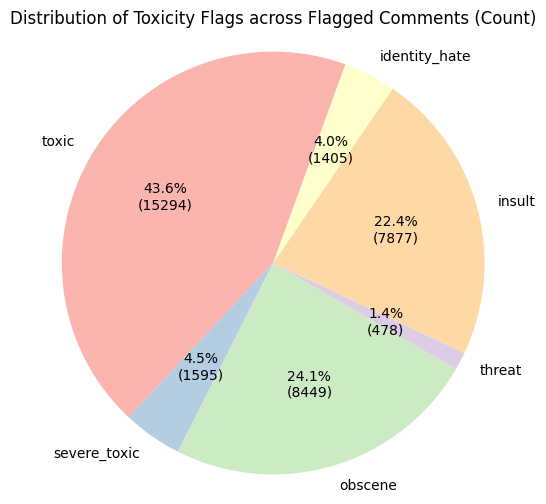

In [13]:
toxicity_flags = toxictrain_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Count of each label where label = 1
toxicity_counts = toxicity_flags.sum()

# Remove data where label = 0
toxicity_counts = toxicity_counts.loc[toxicity_counts > 0]

# Defining custom autopct function to show both count and percentage
def autopct_format(values):
    def pct_num_format(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return pct_num_format

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    toxicity_counts.values,
    labels=toxicity_counts.index,
    autopct=autopct_format(toxicity_counts.values),
    startangle=70,
    colors=plt.cm.Pastel1.colors
)
plt.title('Distribution of Toxicity Flags across Flagged Comments (Count)')
plt.axis('equal')  # Equal aspect ratio
plt.show()

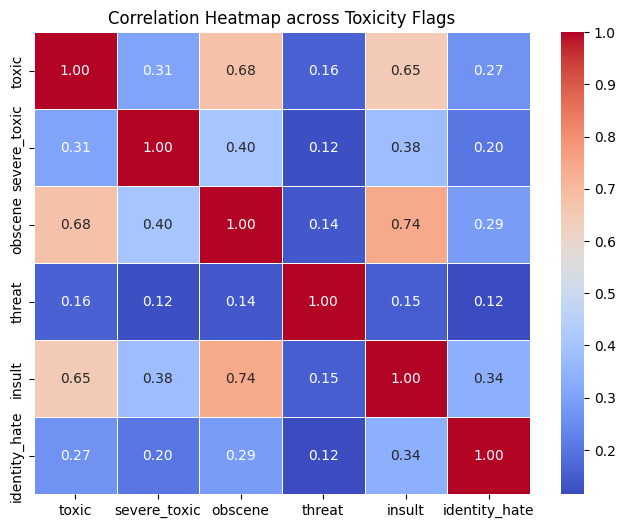

In [14]:
heatmap_corr = toxicity_flags.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Heatmap across Toxicity Flags')

plt.show()

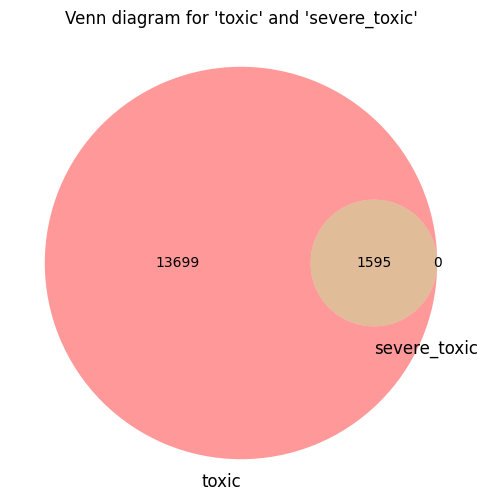

In [15]:
# 2-feature Venn diagram for 'toxic' and 'severe_toxic'
tox = toxictrain_df[(toxictrain_df['toxic'] == 1) & (toxictrain_df['severe_toxic'] == 0)].shape[0]
stox = toxictrain_df[(toxictrain_df['toxic'] == 0) & (toxictrain_df['severe_toxic'] == 1)].shape[0]

tox_stox = toxictrain_df[(toxictrain_df['toxic'] == 1) & (toxictrain_df['severe_toxic'] == 1)].shape[0]

plt.figure(figsize=(6, 6))
plt.title("Venn diagram for 'toxic' and 'severe_toxic'")
venn2(subsets = (tox, stox, tox_stox), 
      set_labels=('toxic', 'severe_toxic'))
plt.show()

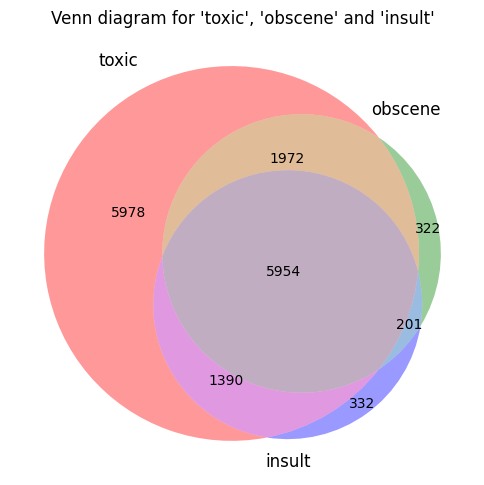

In [16]:
# 3-feature Venn diagram for 'toxic', 'obscene' and 'insult'
tox = toxictrain_df[(toxictrain_df['toxic'] == 1) & (toxictrain_df['obscene'] == 0) & (toxictrain_df['insult'] == 0)].shape[0]
obs = toxictrain_df[(toxictrain_df['toxic'] == 0) & (toxictrain_df['obscene'] == 1) & (toxictrain_df['insult'] == 0)].shape[0]
ins = toxictrain_df[(toxictrain_df['toxic'] == 0) & (toxictrain_df['obscene'] == 0) & (toxictrain_df['insult'] == 1)].shape[0]

tox_obs = toxictrain_df[(toxictrain_df['toxic'] == 1) & (toxictrain_df['obscene'] == 1) & (toxictrain_df['insult'] == 0)].shape[0]
tox_ins = toxictrain_df[(toxictrain_df['toxic'] == 1) & (toxictrain_df['obscene'] == 0) & (toxictrain_df['insult'] == 1)].shape[0]
obs_ins = toxictrain_df[(toxictrain_df['toxic'] == 0) & (toxictrain_df['obscene'] == 1) & (toxictrain_df['insult'] == 1)].shape[0]

tox_obs_ins = toxictrain_df[(toxictrain_df['toxic'] == 1) & (toxictrain_df['obscene'] == 1) & (toxictrain_df['insult'] == 1)].shape[0]

# Make the diagram
plt.figure(figsize=(6, 6))
plt.title("Venn diagram for 'toxic', 'obscene' and 'insult'")
venn3(subsets = (tox, obs, tox_obs, ins, tox_ins, obs_ins, tox_obs_ins), 
      set_labels=('toxic', 'obscene', 'insult'))
plt.show()

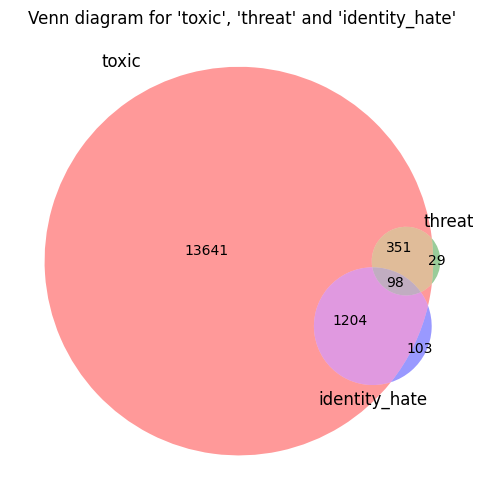

In [17]:
# 3-feature Venn diagram for 'toxic', 'threat' and 'identity_hate'
tox = toxictrain_df[(toxictrain_df['toxic'] == 1) & (toxictrain_df['threat'] == 0) & (toxictrain_df['identity_hate'] == 0)].shape[0]
thr = toxictrain_df[(toxictrain_df['toxic'] == 0) & (toxictrain_df['threat'] == 1) & (toxictrain_df['identity_hate'] == 0)].shape[0]
hate = toxictrain_df[(toxictrain_df['toxic'] == 0) & (toxictrain_df['threat'] == 0) & (toxictrain_df['identity_hate'] == 1)].shape[0]

tox_thr = toxictrain_df[(toxictrain_df['toxic'] == 1) & (toxictrain_df['threat'] == 1) & (toxictrain_df['identity_hate'] == 0)].shape[0]
tox_hate = toxictrain_df[(toxictrain_df['toxic'] == 1) & (toxictrain_df['threat'] == 0) & (toxictrain_df['identity_hate'] == 1)].shape[0]
thr_hate = toxictrain_df[(toxictrain_df['toxic'] == 0) & (toxictrain_df['threat'] == 1) & (toxictrain_df['identity_hate'] == 1)].shape[0]

tox_thr_hate = toxictrain_df[(toxictrain_df['toxic'] == 1) & (toxictrain_df['threat'] == 1) & (toxictrain_df['identity_hate'] == 1)].shape[0]

# Make the diagram
plt.figure(figsize=(6, 6))
plt.title("Venn diagram for 'toxic', 'threat' and 'identity_hate'")
venn3(subsets = (tox, thr, tox_thr, hate, tox_hate, thr_hate, tox_thr_hate), 
      set_labels=('toxic', 'threat', 'identity_hate'))
plt.show()

In [18]:
# Generation of token list for loading into Tableau (each token is from a unique comment, and labelled with the appropriate toxicity flags tied with said comment)
# Select columns and explode tokens
toxicity_flags = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'flagged']
toxictrain_df_allexploded = toxictrain_df[toxicity_flags + ['tokens']].explode('tokens')

# Rename token column to 'word'
toxictrain_df_allexploded = toxictrain_df_allexploded.rename(columns={'tokens': 'word'})

# Lowercasing + Removal of whitespacing
toxictrain_df_allexploded['word'] = toxictrain_df_allexploded['word'].str.lower().str.strip()

# Drop rows where all flags are 0
toxictrain_df_filtered = toxictrain_df_allexploded[toxictrain_df_allexploded[toxicity_flags].sum(axis=1) > 0]

# Export to CSV
toxictrain_df_filtered.to_csv("word_cloud_toxic_only.csv", index=False)

In [19]:
# Generation of token list for loading into Tableau (count of each token for the corresponding toxicity flag is measured)
# Select columns
toxicity_flags = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'flagged']

# Explode tokens into individual rows
toxictrain_df_exploded = toxictrain_df[toxicity_flags + ['tokens']].explode('tokens')
toxictrain_df_exploded = toxictrain_df_exploded.rename(columns={'tokens': 'word'})
toxictrain_df_exploded['word'] = toxictrain_df_exploded['word'].str.lower().str.strip()

# Melt the data to long format (one row per word+flag where flag == 1)
toxictrain_df_long = toxictrain_df_exploded.melt(
    id_vars='word',
    value_vars=toxicity_flags,
    var_name='flag_type',
    value_name='is_flagged'
)

# Keep only toxic words (flagged == 1)
toxictrain_df_flagged_words = toxictrain_df_long[toxictrain_df_long['is_flagged'] == 1]

# Count frequency
toxictrain_df_flagged_freq = toxictrain_df_flagged_words.groupby(['flag_type', 'word']).size().reset_index(name='count')

# Export to CSV
toxictrain_df_flagged_freq.to_csv("tableau_word_cloud_per_flag.csv", index=False)

In [20]:
# New dictionary + Define column headers to extract words from
word_counter = {}
column_headers = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Lowercasing + Punctuation and Stopword Removals
def clean_text(text):
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in (stop_words)])

# Looping through each column header
for toxflag in column_headers:
    c = Counter()
    toxictrain_df[toxictrain_df[toxflag] == 1]['comment_text'].apply(lambda t: c.update(clean_text(t).split()))
    word_counter[toxflag] = pd.DataFrame.from_dict(c, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

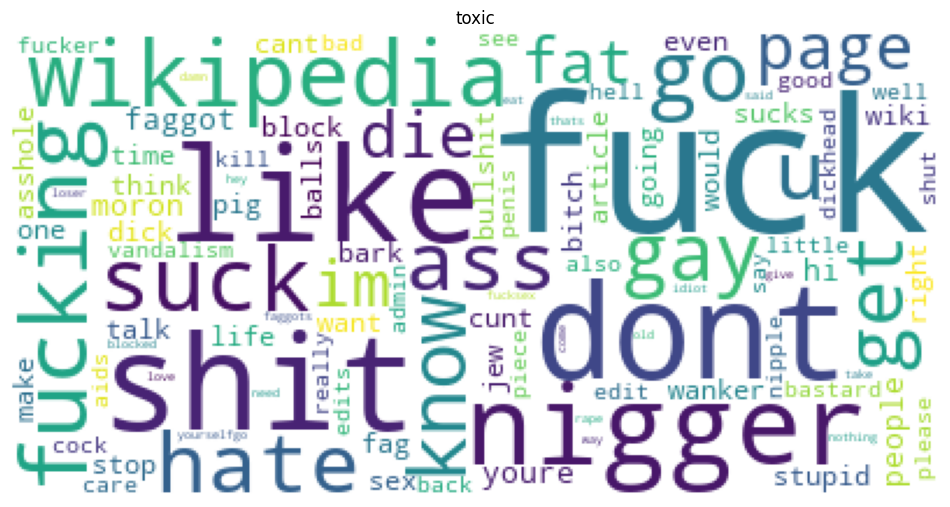

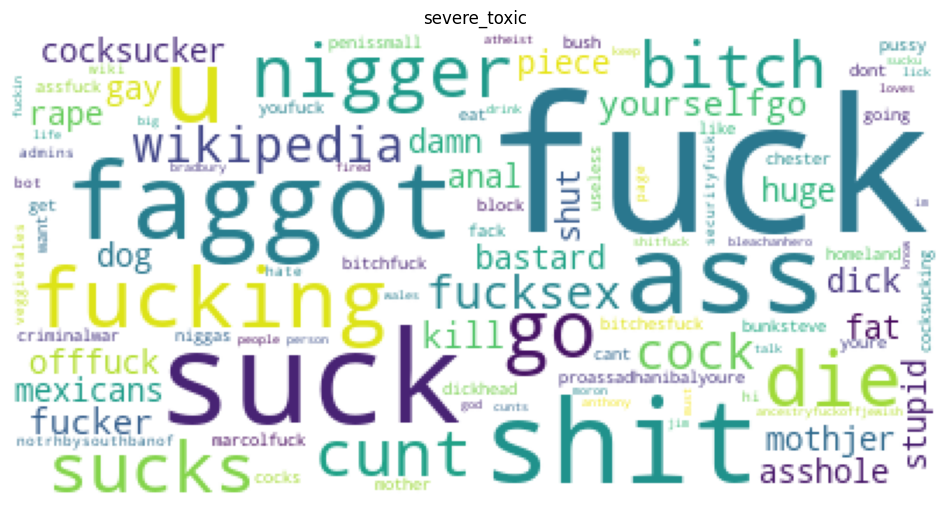

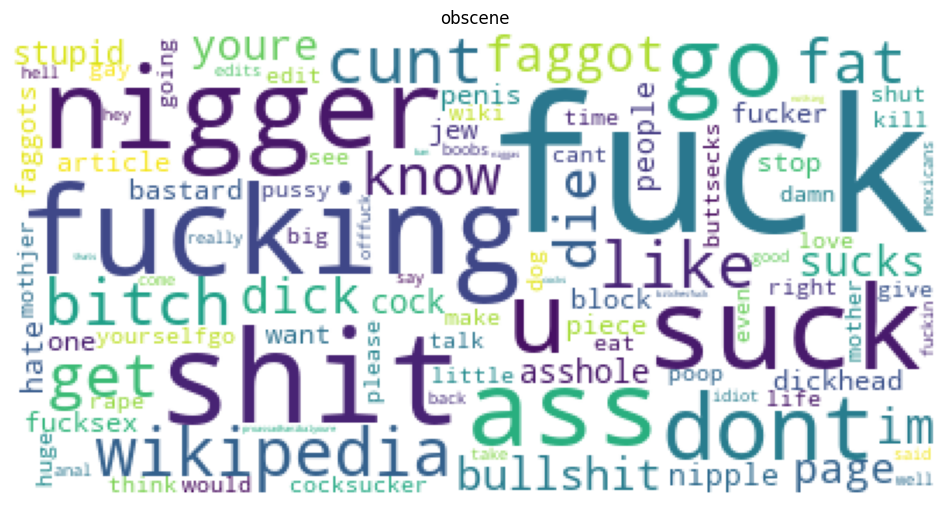

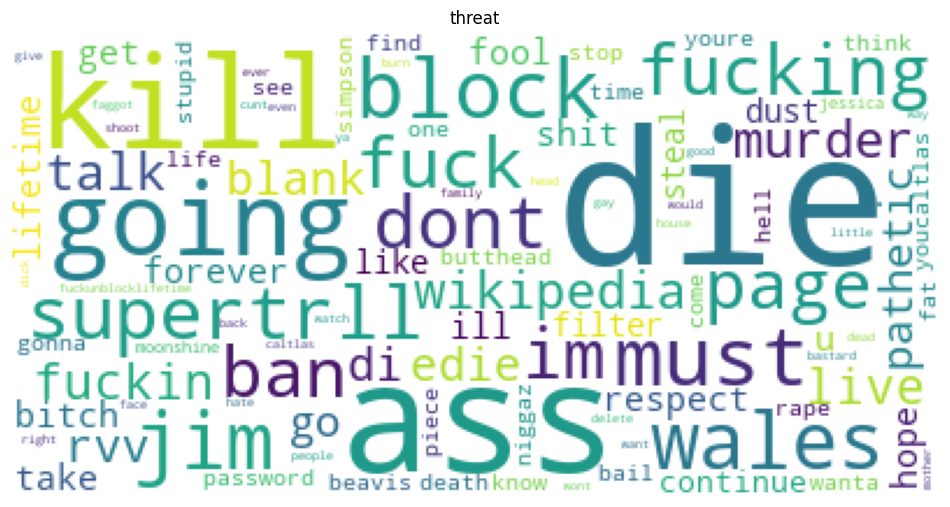

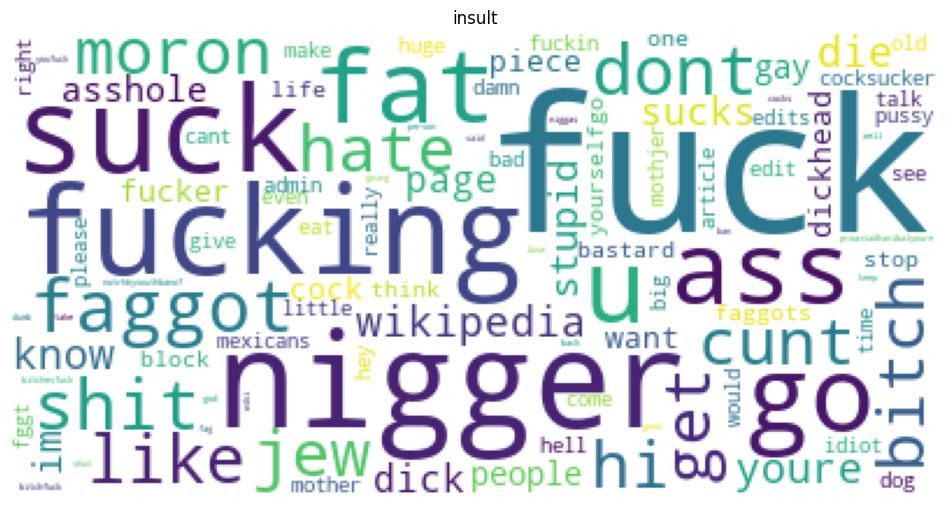

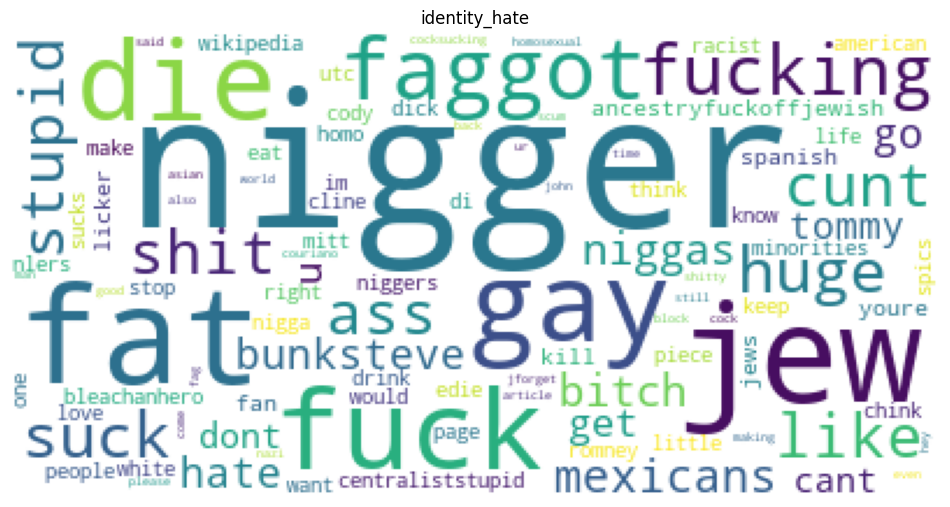

In [21]:
# Generation of word bank and plotting of word cloud 
for w in word_counter:
    wc = word_counter[w]

    wordcloud = WordCloud(
          background_color='white',
          max_words=100,
          max_font_size=80, 
          random_state=7
         ).generate_from_frequencies(wc.to_dict()['count'])

    fig = plt.figure(figsize=(12, 8))
    plt.title(w)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

In [22]:
from collections import Counter

# Filter rows where 'flagged' == 1
flagged_rows = toxictrain_df[toxictrain_df['flagged'] == 1]

# Flatten the list of tokens into one big list
all_flagged_tokens = flagged_rows['tokens'].sum()

# Count word frequencies
word_freq = Counter(all_flagged_tokens)

# View top 20 most common words
print(word_freq.most_common(10))

[('fuck', 8753), ('suck', 4495), ('like', 3898), ('dont', 3886), ('shit', 3673), ('wikipedia', 3485), ('nigger', 3423), ('fucking', 3241), ('u', 3181), ('go', 3082)]


In [23]:
# Calculating total no. of generated tokens from full dataset
all_tokens = [token for sublist in toxictrain_df['tokens'] for token in sublist]
print(all_tokens[:50])   # First 50 tokens
print(len(all_tokens)) # Total no. of tokens

['explanation', 'edits', 'made', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'werent', 'vandalism', 'closure', 'gas', 'voted', 'new', 'york', 'doll', 'fac', 'please', 'dont', 'remove', 'template', 'talk', 'page', 'since', 'im', 'retired', 'daww', 'match', 'background', 'colour', 'im', 'seemingly', 'stuck', 'thanks', 'talk', 'january', 'utc', 'hey', 'man', 'im', 'really', 'trying', 'edit', 'war', 'guy', 'constantly', 'removing', 'relevant', 'information', 'talking']
5461520


In [24]:
# defining individual features seen in raw dataset, including the y7 that we engineered
X = toxictrain_df['comment_text']
y1 = toxictrain_df['toxic']
y2 = toxictrain_df['severe_toxic']
y3 = toxictrain_df['obscene']
y4 = toxictrain_df['threat']
y5 = toxictrain_df['insult']
y6 = toxictrain_df['identity_hate']
y7 = toxictrain_df['flagged']

In [25]:
# Check what we need to check in a classification problem. - distribution of classes in `y` for choosing appropriate metrics
y1.value_counts(normalize = True)

toxic
0    0.904156
1    0.095844
Name: proportion, dtype: float64

In [26]:
y2.value_counts(normalize = True)

severe_toxic
0    0.990004
1    0.009996
Name: proportion, dtype: float64

In [27]:
y3.value_counts(normalize = True)

obscene
0    0.947052
1    0.052948
Name: proportion, dtype: float64

In [28]:
y4.value_counts(normalize = True)

threat
0    0.997004
1    0.002996
Name: proportion, dtype: float64

In [29]:
y5.value_counts(normalize = True)

insult
0    0.950636
1    0.049364
Name: proportion, dtype: float64

In [30]:
y6.value_counts(normalize = True)

identity_hate
0    0.991195
1    0.008805
Name: proportion, dtype: float64

In [31]:
y7.value_counts(normalize = True)

flagged
0    0.898321
1    0.101679
Name: proportion, dtype: float64

#### Preparation of Dataset for Modeling (Train-Test Split (80:20))

In [32]:
# Split the data into the training and testing sets.
X_train, X_test, y7_train, y7_test = train_test_split(X,
                                                    y7,
                                                    test_size=0.20,
                                                    stratify=y7,
                                                    random_state=7)

In [33]:
X_train

84877     hi did you recently email accountstargatewikio...
41067       its been released by all sources i bought my...
11775        your recent article moves   there have been...
149726    indeed it does a close friend described that w...
67842       fine by me looks like the only edit i ever m...
                                ...                        
68387        blanking of contributions has to stop   the...
62416     fguerino  that is just part of his signature  ...
57078      i wonder if  user claim the earth is flat the...
92886     september  utc  look agent orange i dont care ...
36793        the lakers fc   hello  this is regarding no...
Name: comment_text, Length: 127656, dtype: object

In [34]:
# No. of rows in train data
print(X_train.iloc[0])
X_train.shape

hi did you recently email accountstargatewikiorg about an account please only reply from this account not an ip 


(127656,)

#### Preparation of dataset (TF-IDF Vectoriser on Train data)

In [35]:
# Instantiate TF-IDF Vectoriser
tvec = TfidfVectorizer()

# Fit the vectorizer on X_train
X_train_tvec = tvec.fit_transform(X_train)
X_train_tvec

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5406670 stored elements and shape (127656, 193439)>

#### Preparation of dataset (Count Vectoriser on Train data)

In [36]:
# Customising a tokeniser with Lowercasing + Removal of non-alphabetic characters +  Lemmatising qualities
def cvec_custom_tokenizer(text):

    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)

    tokens = nltk.word_tokenize(text)
    return [lemmatizer.lemmatize(token) for token in tokens]

In [37]:
# Instantiate CountVectorizer with standard hyperparameters (stop_words, min_df, max_df) and customised tokeniser
cvec = CountVectorizer(
    tokenizer = cvec_custom_tokenizer,
    stop_words = 'english',
    min_df = 10,
    max_df = 0.7
)

# Fit the vectorizer on X_train
X_train_cvec = cvec.fit_transform(X_train)
X_train_cvec

C:\Users\sigpr\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\sigpr\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2829858 stored elements and shape (127656, 17081)>

In [38]:
# Conversion of the vectorised data into an array
X_train_cvec[:10].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(10, 17081))

In [39]:
# Quick check on 1st row in train data
print(X_train.iloc[0])

hi did you recently email accountstargatewikiorg about an account please only reply from this account not an ip 


In [40]:
# Quick check on 1st row of vectorised data array
X_train_cvec.toarray()[0]

array([0, 0, 0, ..., 0, 0, 0], shape=(17081,))

In [41]:
# Quick check on first 10 feature column names (unique words) in vectorised data array with .get_feature_names_out
cvec.get_feature_names_out()[:10]

array(['aa', 'aap', 'aardvark', 'aaron', 'ab', 'abandon', 'abandoned',
       'abandoning', 'abandonment', 'abbas'], dtype=object)

In [42]:
# Printing random values in column index 1000 to 1005
cvec.get_feature_names_out()[1000:1005]

array(['aspiration', 'aspiring', 'ass', 'assad', 'assange'], dtype=object)

In [43]:
# Printing non-zero feature column names (unique words) in 1st row of X_train
for index, element in enumerate(X_train_cvec.toarray()[0]): # iterate over both index, element (count value of a unique word)
    if element!=0:
        print(index, cvec.get_feature_names_out()[index])

114 account
4199 did
4938 email
6954 hi
7922 ip
12157 recently
12510 reply


In [44]:
X_test.shape

(31915,)

In [45]:
# Convert vectorized training data to dataframe
X_train_df = pd.DataFrame(X_train_cvec.toarray(), columns=cvec.get_feature_names_out())
X_train_df.head()

,aa,aap,aardvark,aaron,ab,abandon,abandoned,abandoning,abandonment,abbas,...,zodiac,zoe,zombie,zone,zoo,zoom,zora,zoroastrian,zu,zzuuzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# Top 10 most frequent words in X_train, sorted by largest to smallest sum
X_train_df.sum().sort_values(ascending=False).head(10)

article      58130
page         45140
wa           43163
wikipedia    28492
talk         25519
ha           25198
like         22794
just         22213
dont         20980
source       17169
dtype: int64

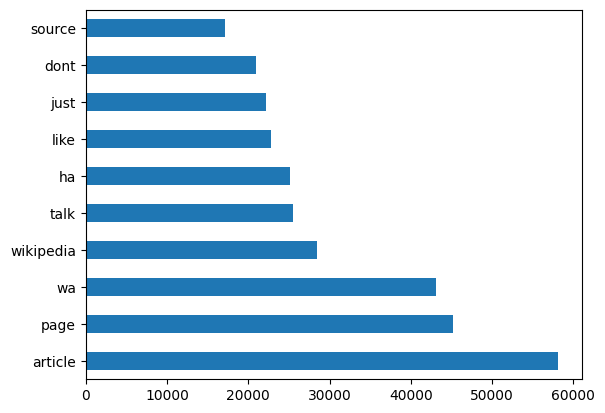

In [47]:
# Plot top 10 most freqeuent words in X_train into horizontal bar chart
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind="barh");

#### Baseline Modeling (Count Vec. + Dummy Classifier Model Combo)

In [48]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, recall_score, f1_score

# Create and train the baseline model using 'stratified', to ensure that class distribution of X_train is taken into account
baseline_model = DummyClassifier(strategy='stratified')
baseline_model.fit(X_train_cvec, y7_train)

y7_cvec_baseline_pred = baseline_model.predict(X_test)

print("Stratified Baseline Model (Count Vectoriser & Dummy Classifier Model)")
print(classification_report(y7_test, y7_cvec_baseline_pred, digits=4))

Stratified Baseline Model (Count Vectoriser & Dummy Classifier Model)
              precision    recall  f1-score   support

           0     0.8973    0.9003    0.8988     28670
           1     0.0921    0.0894    0.0907      3245

    accuracy                         0.8179     31915
   macro avg     0.4947    0.4948    0.4948     31915
weighted avg     0.8154    0.8179    0.8166     31915



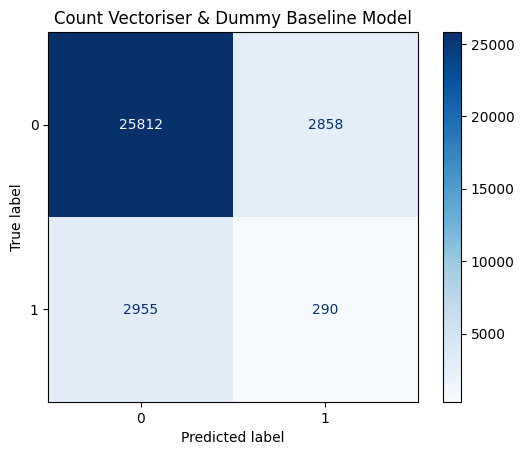

In [49]:
# Plotting confusion matrix
cvec_base_cm = confusion_matrix(y7_test, y7_cvec_baseline_pred)

cvec_base_cmdisp = ConfusionMatrixDisplay(confusion_matrix=cvec_base_cm)
cvec_base_cmdisp.plot(cmap='Blues')
plt.title("Count Vectoriser & Dummy Baseline Model")
plt.show()

#### Baseline Modeling (TF-IDF Vec. + Dummy Classifier Model Combo)

In [50]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, recall_score, f1_score

# Create and train the baseline model using 'stratified', to ensure that class distribution of X_train is taken into account
baseline_model = DummyClassifier(strategy='stratified')
baseline_model.fit(X_train_tvec, y7_train)

y7_tvec_baseline_pred = baseline_model.predict(X_test)

print("Stratified Baseline Model (TF-IDF Vectoriser & Dummy Classifier Model)")
print(classification_report(y7_test, y7_tvec_baseline_pred, digits=4))

Stratified Baseline Model (TF-IDF Vectoriser & Dummy Classifier Model)
              precision    recall  f1-score   support

           0     0.8989    0.8982    0.8986     28670
           1     0.1068    0.1076    0.1072      3245

    accuracy                         0.8178     31915
   macro avg     0.5029    0.5029    0.5029     31915
weighted avg     0.8184    0.8178    0.8181     31915



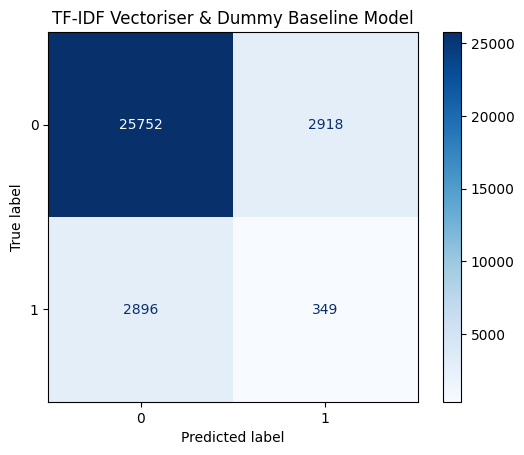

In [51]:
# Plotting confusion matrix
tvec_base_cm = confusion_matrix(y7_test, y7_tvec_baseline_pred)

tvec_base_cmdisp = ConfusionMatrixDisplay(confusion_matrix=tvec_base_cm)
tvec_base_cmdisp.plot(cmap='Blues')
plt.title("TF-IDF Vectoriser & Dummy Baseline Model")
plt.show()

#### Count Vec. + Log. Regression Model Combo

In [52]:
cvec_logr_model = linear_model.LogisticRegression(max_iter=1000)
cvec_logr_model.fit(X_train_cvec, y7_train)

LogisticRegression(max_iter=1000)

In [53]:
X_test_cvec = cvec.transform(X_test)

In [54]:
# Predict on test data
toxictest_cvec_logr_pred = cvec_logr_model.predict(X_test_cvec)

In [55]:
# Frame X_test into DataFrame format and resetting index, to facilitate .csv export later
X_test_df = X_test.to_frame().reset_index(drop=True)

# Reset y7_test index, to ensure correct alignment of data rows with X_test_df
y7_test_reset = y7_test.reset_index(drop=True)

# Creating full DataFrame with Actual / Predicted columns
results_cvec_logr_df = pd.DataFrame({
    'comment_text': X_test_df['comment_text'],
    'Actual': y7_test_reset,
    'Predicted': toxictest_cvec_logr_pred
})

# Adding new column "Misclassified", to facilitate data referencing in .csv file
results_cvec_logr_df['Misclassified'] = results_cvec_logr_df['Actual'] != results_cvec_logr_df['Predicted']

print(results_cvec_logr_df.head(10))

                                        comment_text  Actual  Predicted  \
0  please help   all my improvements and correcti...       0          0   
1  help could someone please help me with this ar...       0          0   
2   where are you from man you can find many docu...       0          0   
3  reworking of lead   i wandered into this artic...       0          0   
4    i have aspbergers i know the ocndition reall...       0          0   
5  paul tibbit is a fuckingass little piece of sm...       1          1   
6  hahahahahahahahahahahahahahahahahaha vandalism...       1          1   
7  i would staunchly disagree davids collapsible ...       0          0   
8  hi im looking for adoption and notice that we ...       0          0   
9    july     the cumberland gap was discovered b...       0          0   

   Misclassified  
0          False  
1          False  
2          False  
3          False  
4          False  
5          False  
6          False  
7          False  
8  

In [56]:
# Exporting above to .csv
results_cvec_logr_df.to_csv('cvec_logr_test_predictions.csv', index=False)

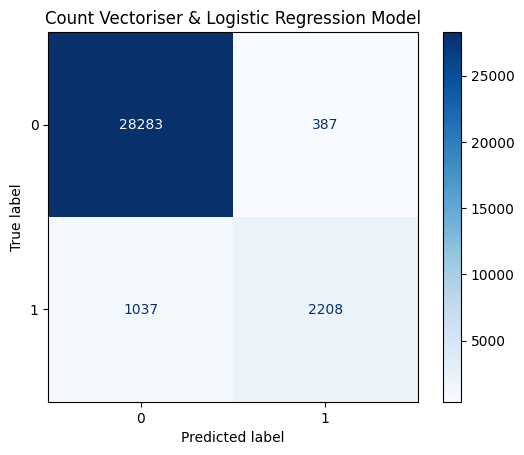

In [57]:
# Plotting confusion matrix
cvec_logr_cm = confusion_matrix(y7_test, toxictest_cvec_logr_pred)

cvec_logr_cmdisp = ConfusionMatrixDisplay(confusion_matrix=cvec_logr_cm)
cvec_logr_cmdisp.plot(cmap='Blues')
plt.title("Count Vectoriser & Logistic Regression Model")
plt.show()

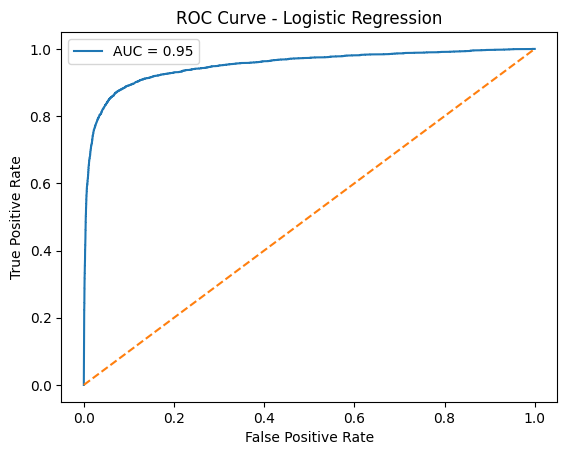

In [58]:
# Plotting ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

y_cvec_logr_probs = cvec_logr_model.predict_proba(X_test_cvec)[:, 1]

fpr, tpr, thresholds = roc_curve(y7_test, y_cvec_logr_probs)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y7_test, y_cvec_logr_probs):.2f}')
plt.plot([0,1], [0,1], linestyle='--')  # Random model line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

In [59]:
# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y7_test, toxictest_cvec_logr_pred))

# Detailed report
print("\nClassification Report (Count Vectoriser & Logistic Regression Model):")
print(classification_report(y7_test, toxictest_cvec_logr_pred, digits=4))


Confusion Matrix:
[[28283   387]
 [ 1037  2208]]

Classification Report (Count Vectoriser & Logistic Regression Model):
              precision    recall  f1-score   support

           0     0.9646    0.9865    0.9754     28670
           1     0.8509    0.6804    0.7562      3245

    accuracy                         0.9554     31915
   macro avg     0.9077    0.8335    0.8658     31915
weighted avg     0.9531    0.9554    0.9531     31915



In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y7_test, toxictest_cvec_logr_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y7_test, toxictest_cvec_logr_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y7_test, toxictest_cvec_logr_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y7_test, toxictest_cvec_logr_pred)
print('F1 score: %f' % f1)

Accuracy: 0.955381
Precision: 0.850867
Recall: 0.680431
F1 score: 0.756164


#### TF-IDF Vec. + Log. Regression Model Combo

In [61]:
tvec_logr_model = linear_model.LogisticRegression(max_iter=1000)
tvec_logr_model.fit(X_train_tvec, y7_train)

LogisticRegression(max_iter=1000)

In [62]:
X_test_tvec = tvec.transform(X_test)

In [63]:
# Predict on test data
toxictest_tvec_logr_pred = tvec_logr_model.predict(X_test_tvec)

In [64]:
# Frame X_test into DataFrame format and resetting index, to facilitate .csv export later
X_test_df = X_test.to_frame().reset_index(drop=True)

# Reset y7_test index, to ensure correct alignment of data rows with X_test_df
y7_test_reset = y7_test.reset_index(drop=True)

# Creating full DataFrame with Actual / Predicted columns
results_tvec_logr_df = pd.DataFrame({
    'comment_text': X_test_df['comment_text'],
    'Actual': y7_test_reset,
    'Predicted': toxictest_tvec_logr_pred
})

# Adding new column "Misclassified", to facilitate data referencing in .csv file
results_tvec_logr_df['Misclassified'] = results_tvec_logr_df['Actual'] != results_tvec_logr_df['Predicted']

print(results_tvec_logr_df.head(10))

                                        comment_text  Actual  Predicted  \
0  please help   all my improvements and correcti...       0          0   
1  help could someone please help me with this ar...       0          0   
2   where are you from man you can find many docu...       0          0   
3  reworking of lead   i wandered into this artic...       0          0   
4    i have aspbergers i know the ocndition reall...       0          0   
5  paul tibbit is a fuckingass little piece of sm...       1          1   
6  hahahahahahahahahahahahahahahahahaha vandalism...       1          0   
7  i would staunchly disagree davids collapsible ...       0          0   
8  hi im looking for adoption and notice that we ...       0          0   
9    july     the cumberland gap was discovered b...       0          0   

   Misclassified  
0          False  
1          False  
2          False  
3          False  
4          False  
5          False  
6           True  
7          False  
8  

In [65]:
# Exporting above to .csv
results_tvec_logr_df.to_csv('tvec_logr_test_predictions.csv', index=False)

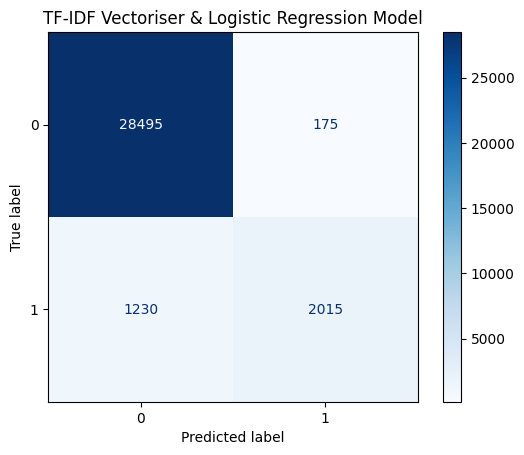

In [66]:
# Plotting confusion matrix
tvec_logr_cm = confusion_matrix(y7_test, toxictest_tvec_logr_pred)

tvec_logr_cmdisp = ConfusionMatrixDisplay(confusion_matrix=tvec_logr_cm)
tvec_logr_cmdisp.plot(cmap='Blues')
plt.title("TF-IDF Vectoriser & Logistic Regression Model")
plt.show()

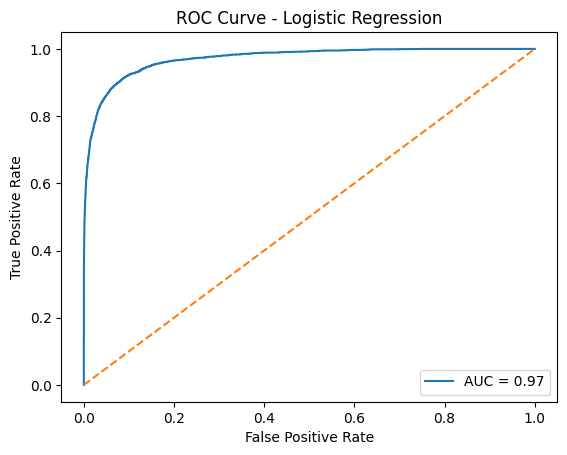

In [67]:
# Plotting ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

y_tvec_logr_probs = tvec_logr_model.predict_proba(X_test_tvec)[:, 1]

fpr, tpr, thresholds = roc_curve(y7_test, y_tvec_logr_probs)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y7_test, y_tvec_logr_probs):.2f}')
plt.plot([0,1], [0,1], linestyle='--')  # Random model line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

In [68]:
print("\nConfusion Matrix:")
print(confusion_matrix(y7_test, toxictest_tvec_logr_pred))

print("\nClassification Report (TF-IDF Vectoriser & Logistic Regression Model):")
print(classification_report(y7_test, toxictest_tvec_logr_pred, digits=4))


Confusion Matrix:
[[28495   175]
 [ 1230  2015]]

Classification Report (TF-IDF Vectoriser & Logistic Regression Model):
              precision    recall  f1-score   support

           0     0.9586    0.9939    0.9759     28670
           1     0.9201    0.6210    0.7415      3245

    accuracy                         0.9560     31915
   macro avg     0.9394    0.8074    0.8587     31915
weighted avg     0.9547    0.9560    0.9521     31915



In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y7_test, toxictest_tvec_logr_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y7_test, toxictest_tvec_logr_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y7_test, toxictest_tvec_logr_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y7_test, toxictest_tvec_logr_pred)
print('F1 score: %f' % f1)

Accuracy: 0.955977
Precision: 0.920091
Recall: 0.620955
F1 score: 0.741490


#### Count Vec. + MultinomialNB (Naive Bayes) Model Combo

In [70]:
cvec_nb_model = MultinomialNB()
cvec_nb_model.fit(X_train_cvec, y7_train)

MultinomialNB()

In [71]:
X_test_cvec = cvec.transform(X_test)

In [72]:
# Predict on test data
toxictest_cvec_nb_pred = cvec_nb_model.predict(X_test_cvec)

In [73]:
# Frame X_test into DataFrame format and resetting index, to facilitate .csv export later
X_test_df = X_test.to_frame().reset_index(drop=True)

# Reset y7_test index, to ensure correct alignment of data rows with X_test_df
y7_test_reset = y7_test.reset_index(drop=True)

# Creating full DataFrame with Actual / Predicted columns
results_cvec_nb_df = pd.DataFrame({
    'comment_text': X_test_df['comment_text'],
    'Actual': y7_test_reset,
    'Predicted': toxictest_cvec_nb_pred
})

# Adding new column "Misclassified", to facilitate data referencing in .csv file
results_cvec_nb_df['Misclassified'] = results_cvec_nb_df['Actual'] != results_cvec_nb_df['Predicted']

print(results_cvec_nb_df.head(10))

                                        comment_text  Actual  Predicted  \
0  please help   all my improvements and correcti...       0          0   
1  help could someone please help me with this ar...       0          0   
2   where are you from man you can find many docu...       0          0   
3  reworking of lead   i wandered into this artic...       0          0   
4    i have aspbergers i know the ocndition reall...       0          0   
5  paul tibbit is a fuckingass little piece of sm...       1          1   
6  hahahahahahahahahahahahahahahahahaha vandalism...       1          0   
7  i would staunchly disagree davids collapsible ...       0          0   
8  hi im looking for adoption and notice that we ...       0          0   
9    july     the cumberland gap was discovered b...       0          0   

   Misclassified  
0          False  
1          False  
2          False  
3          False  
4          False  
5          False  
6           True  
7          False  
8  

In [74]:
# Exporting above to .csv
results_cvec_nb_df.to_csv('cvec_nb_test_predictions.csv', index=False)

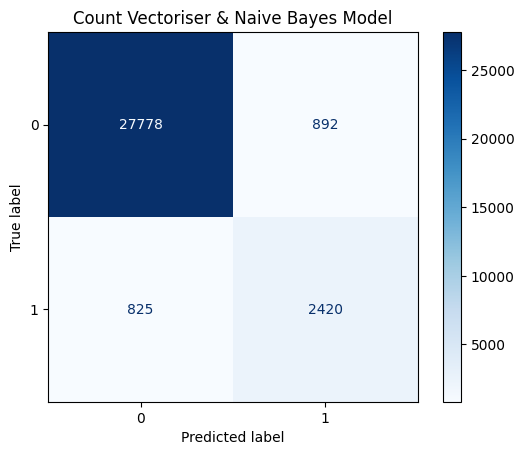

In [75]:
# Plotting confusion matrix
cvec_nb_cm = confusion_matrix(y7_test, toxictest_cvec_nb_pred)

cvec_nb_cmdisp = ConfusionMatrixDisplay(confusion_matrix=cvec_nb_cm)
cvec_nb_cmdisp.plot(cmap='Blues')
plt.title("Count Vectoriser & Naive Bayes Model")
plt.show()

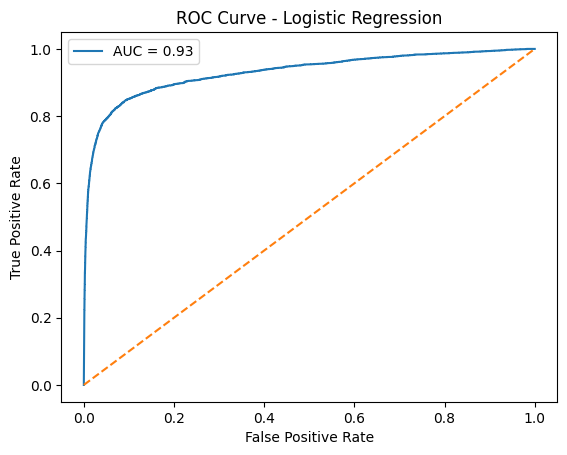

In [76]:
# Plotting ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

y_cvec_nb_probs = cvec_nb_model.predict_proba(X_test_cvec)[:, 1]

fpr, tpr, thresholds = roc_curve(y7_test, y_cvec_nb_probs)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y7_test, y_cvec_nb_probs):.2f}')
plt.plot([0,1], [0,1], linestyle='--')  # Random model line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

In [77]:
print("\nConfusion Matrix:")
print(confusion_matrix(y7_test, toxictest_cvec_nb_pred))

print("\nClassification Report (Count Vectoriser & Naive Bayes Model):")
print(classification_report(y7_test, toxictest_cvec_nb_pred, digits=4))


Confusion Matrix:
[[27778   892]
 [  825  2420]]

Classification Report (Count Vectoriser & Naive Bayes Model):
              precision    recall  f1-score   support

           0     0.9712    0.9689    0.9700     28670
           1     0.7307    0.7458    0.7381      3245

    accuracy                         0.9462     31915
   macro avg     0.8509    0.8573    0.8541     31915
weighted avg     0.9467    0.9462    0.9464     31915



In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y7_test, toxictest_cvec_nb_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y7_test, toxictest_cvec_nb_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y7_test, toxictest_cvec_nb_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y7_test, toxictest_cvec_nb_pred)
print('F1 score: %f' % f1)

Accuracy: 0.946201
Precision: 0.730676
Recall: 0.745763
F1 score: 0.738142


#### TF-IDF Vec. + MultinomialNB (Naive Bayes) Model Combo

In [79]:
tvec_nb_model = MultinomialNB()
tvec_nb_model.fit(X_train_tvec, y7_train)

MultinomialNB()

In [80]:
X_test.head(10)

104655    please help   all my improvements and correcti...
112753    help could someone please help me with this ar...
45117      where are you from man you can find many docu...
122659    reworking of lead   i wandered into this artic...
114298      i have aspbergers i know the ocndition reall...
8326      paul tibbit is a fuckingass little piece of sm...
46583     hahahahahahahahahahahahahahahahahaha vandalism...
106995    i would staunchly disagree davids collapsible ...
2222      hi im looking for adoption and notice that we ...
67050       july     the cumberland gap was discovered b...
Name: comment_text, dtype: object

In [81]:
X_test_tvec = tvec.transform(X_test)

In [82]:
# Predict on test data
toxictest_tvec_nb_pred = tvec_nb_model.predict(X_test_tvec)

In [83]:
# Frame X_test into DataFrame format and resetting index, to facilitate .csv export later
X_test_df = X_test.to_frame().reset_index(drop=True)

# Reset y7_test index, to ensure correct alignment of data rows with X_test_df
y7_test_reset = y7_test.reset_index(drop=True)

# Creating full DataFrame with Actual / Predicted columns
results_tvec_nb_df = pd.DataFrame({
    'comment_text': X_test_df['comment_text'],
    'Actual': y7_test_reset,
    'Predicted': toxictest_tvec_nb_pred
})

# Adding new column "Misclassified", to facilitate data referencing in .csv file
results_tvec_nb_df['Misclassified'] = results_tvec_nb_df['Actual'] != results_tvec_nb_df['Predicted']

print(results_tvec_nb_df.head(10))

                                        comment_text  Actual  Predicted  \
0  please help   all my improvements and correcti...       0          0   
1  help could someone please help me with this ar...       0          0   
2   where are you from man you can find many docu...       0          0   
3  reworking of lead   i wandered into this artic...       0          0   
4    i have aspbergers i know the ocndition reall...       0          0   
5  paul tibbit is a fuckingass little piece of sm...       1          1   
6  hahahahahahahahahahahahahahahahahaha vandalism...       1          0   
7  i would staunchly disagree davids collapsible ...       0          0   
8  hi im looking for adoption and notice that we ...       0          0   
9    july     the cumberland gap was discovered b...       0          0   

   Misclassified  
0          False  
1          False  
2          False  
3          False  
4          False  
5          False  
6           True  
7          False  
8  

In [84]:
# Exporting above to .csv
results_tvec_nb_df.to_csv('tvec_nb_test_predictions.csv', index=False)

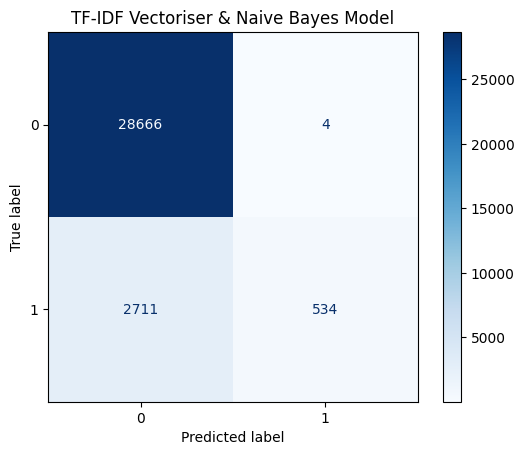

In [85]:
# Plotting confusion matrix
tvec_nb_cm = confusion_matrix(y7_test, toxictest_tvec_nb_pred)

tvec_nb_cmdisp = ConfusionMatrixDisplay(confusion_matrix=tvec_nb_cm)
tvec_nb_cmdisp.plot(cmap='Blues')
plt.title("TF-IDF Vectoriser & Naive Bayes Model")
plt.show()

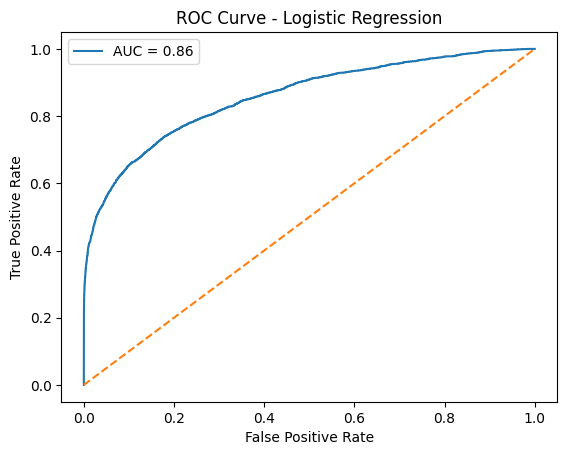

In [86]:
# Plotting ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

y_tvec_nb_probs = tvec_nb_model.predict_proba(X_test_tvec)[:, 1]

fpr, tpr, thresholds = roc_curve(y7_test, y_tvec_nb_probs)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y7_test, y_tvec_nb_probs):.2f}')
plt.plot([0,1], [0,1], linestyle='--')  # Random model line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

print("\nConfusion Matrix:")
print(confusion_matrix(y7_test, toxictest_tvec_nb_pred))

print("\nClassification Report (TF-IDF Vectoriser & Naive Bayes Model):")
print(classification_report(y7_test, toxictest_tvec_nb_pred, digits=4))

In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y7_test, toxictest_tvec_nb_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y7_test, toxictest_tvec_nb_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y7_test, toxictest_tvec_nb_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y7_test, toxictest_tvec_nb_pred)
print('F1 score: %f' % f1)

Accuracy: 0.914930
Precision: 0.992565
Recall: 0.164561
F1 score: 0.282316


### Considering that the Count Vectoriser - Naive Bayes Model Combo scored the best Recall value (74.58%) and also has a competitive F1-Score (73.81%), it is nominated as the best performing vectoriser-model for this project.